# Compute BVA histograms

## Imports

In [1]:
from typing import Dict, List, Tuple

import tqdm

import numpy as np
import pandas as pd

import scipy
import scipy.stats

import seaborn as sns
import matplotlib.pyplot as plt

import pathlib
import tttrlib

import os

## Custom functions

In [2]:
def update_tttr_dict(
    df: pd.DataFrame,
    data_path: pathlib.Path,
    tttrs: Dict[str, tttrlib.TTTR] = dict()    
):
    for ff, fl in zip(df['First File'], df['Last File']):
        try:
            tttr = tttrs[ff]
        except KeyError:
            fn = str(data_path / ff)
            tttr = tttrlib.TTTR(fn, 'HT3')
            #tttr = tttrlib.TTTR(fn, 'PTU')
            #tttr = tttrlib.TTTR(fn, 'SPC-130')
            tttrs[ff] = tttr    
    return tttrs

In [3]:
def read_analysis(
    paris_path : pathlib.Path,
    paths: List[str] = ['bg4', 'br4', 'by4', 'bi4_bur'], #
    file_endings: List[str] = ['bg4', 'br4', 'by4','bur']  # 
) -> (pd.DataFrame, Dict[str, tttrlib.TTTR]):
    
    info_path = paris_path / 'Info'
    data_path = paris_path.parent

    dfs = list()
    for path, ending in zip(paths, file_endings):
        frames = list()
        for fn in sorted((paris_path / path).glob('*.%s' % ending)):
            with open(fn) as f:
                t = f.readlines()
                #if structure added to accommodate bur files which do not have '\n' col.
                if ending == 'bur':
                    h = t[0].split('\t')
                else:
                    h = t[0].split('\t')[:-1]
                #print(str(len(h)) + path) 'for debugging'
                d = [[x for x in l.split('\t')] for l in t[2::2]]
                frames.append(pd.DataFrame(d, columns=h))
        path_df = pd.concat(frames)
        dfs.append(path_df)
    df = pd.concat(dfs, axis=1)
    
#     df = df.dropna()
    
    # Loop through each column and attempt to convert to numeric
    for column in df.columns:
        try:
            df[column] = pd.to_numeric(df[column])
        except ValueError:
            # Handle exceptions, e.g., if the column contains non-numeric values
            print(f"Could not convert {column} to numeric")
    tttrs = dict()
    update_tttr_dict(df, data_path, tttrs)
    return df, tttrs

In [4]:
def compute_bva_mean_std(
    df: pd.DataFrame, # Target data frame
    green_channels = [0, 2],  
    #green_channels = [0, 8],  
    green_micro_time_ranges = [(0, 12499)], # First & Last Channel Number (Prompt) PQ HydraHarp (TAC Channels)
    red_channels: List[int] = [1, 3],
    #red_channels: List[int] = [1, 9],
    red_micro_time_ranges: List[Tuple[int, int]] = [(0, 12499)], # First & Last Channel Number (Prompt) PQ HydraHarp (TAC Channels)
    minimum_window_length: float = 0.01,  # size of time window within burst
    number_of_photons_per_slice: int = -1
):
    # Iterate through rows using iterrows()
    proximity_ratios_mean, proximity_ratios_sd = list(), list()
    mt_green_mean, mt_green_sd = list(), list()
    mt_red_mean, mt_red_sd = list(), list()
    for index, row in tqdm.tqdm(df.iterrows(), total=df.shape[0]):
        
        # Select tttr data of burst out of dictionary
        ff, fl = row['First File'], row['Last File']
        tttr = tttrs[ff]
        #time_calibration = tttr.header.tag('MeasDesc_GlobalResolution')['value'] # For PTU Files
        time_calibration = 1/(tttr.header.tag('SyncRate')['value']) # For HT3 files
        #time_calibration = 5.00E-8
        #print(time_calibration) # 50 ns 5E-8
        
        # Select events within burst
        burst_start, burst_stop = int(row['First Photon']), int(row['Last Photon'])
        burst_tttr = tttr[burst_start:burst_stop]
        
        # Either select TWs by the number of photons in a TW or by the number of photons
        if number_of_photons_per_slice < 0:
            
            # Split burst into time windows
            burst_tws = burst_tttr.get_ranges_by_time_window(minimum_window_length, macro_time_calibration=time_calibration)
            burst_tws = burst_tws.reshape((len(burst_tws)//2, 2))
            
            # Create tttr objects of burst TWs
            burst_tws_tttr = [burst_tttr[start: stop] for start, stop in burst_tws]
        else:
            # Split bursts into chunks with a certain number of photons
            chunk_size = number_of_photons_per_slice
            burst_tws_tttr = [burst_tttr[i:i+chunk_size] for i in range(0, len(burst_tttr), chunk_size)]
    
        # Compute for each time window in a burst the proximity ratio
        n_red, n_green = list(), list()
        mt_green, mt_red = list(), list()
        for tw_tttr in burst_tws_tttr:            
            # mask all photons that are not donor photons
            mask_donor = tttrlib.TTTRMask()
            mask_donor.select_channels(tw_tttr, green_channels)
            mask_donor.select_microtime_ranges(tw_tttr, green_micro_time_ranges)
            
            # mask all photons that are not acceptor photons
            mask_acceptor = tttrlib.TTTRMask()
            mask_acceptor.select_channels(tw_tttr, red_channels)
            mask_acceptor.select_microtime_ranges(tw_tttr, red_micro_time_ranges)
            
            # Assign time window to selector
            mask_donor.set_tttr(tw_tttr)
            mask_acceptor.set_tttr(tw_tttr)
            
            # Get number of green and red photons in TW
            n_green.append(len(mask_donor.get_indices()))
            n_red.append(len(mask_acceptor.get_indices()))

            # Get the mean micro time
            mt_green.append(tw_tttr[mask_donor.get_indices()].get_mean_microtime())
            mt_red.append(tw_tttr[mask_acceptor.get_indices()].get_mean_microtime())

        # Compute mean and sd of intensities
        tw_n_red = np.array(n_red)
        tw_n_green = np.array(n_green)
        
        tw_proximity_ratios = tw_n_red / (tw_n_green + tw_n_red)
        proximity_ratio_mean, proximity_ratio_sd = tw_proximity_ratios.mean(), tw_proximity_ratios.std()
        proximity_ratios_mean.append(proximity_ratio_mean)
        proximity_ratios_sd.append(proximity_ratio_sd)

        # Compute mean and sd of microtimes
        mt_green = np.array(mt_green)
        mt_green_mean.append(mt_green.mean())
        mt_green_sd.append(mt_green.std())

        mt_red = np.array(mt_red)
        mt_red_mean.append(mt_red.mean())
        mt_red_sd.append(mt_red.std())

    proximity_ratios_mean = np.array(proximity_ratios_mean)
    proximity_ratios_sd = np.array(proximity_ratios_sd)
    df['Proximity Ratio Mean'] = proximity_ratios_mean
    df['Proximity Ratio Std'] = proximity_ratios_sd
    
    df['Microtime Green Mean'] = mt_green_mean
    df['Microtime Green Std'] = mt_green_sd

    df['Microtime Red Mean'] = mt_red_mean
    df['Microtime Red Std'] = mt_red_sd

In [5]:
def compute_bva_meanE_stdE(
    df: pd.DataFrame, # Target data frame
    
    green_channels = [0, 2],  # Clemson Detectors
    #green_channels = [0, 8],  # HHU Detectors
    green_micro_time_ranges = [(0, 12499)], # First & Last Channel Number (Prompt) PQ HydraHarp (TAC Channels)
    
    red_channels: List[int] = [1, 3], # Clemson Detectors
    #red_channels: List[int] = [1, 9], # HHU Detectors
    red_micro_time_ranges: List[Tuple[int, int]] = [(0, 12499)], # First & Last Channel Number (Prompt) PQ HydraHarp (TAC Channels)
    
    yellow_channels: List[int] = [1, 3], # Clemson Detectors
    #red_channels: List[int] = [1, 9], # HHU Detectors
    yellow_micro_time_ranges: List[Tuple[int, int]] = [(12500, 25000)], # First & Last Channel Number (Prompt) PQ HydraHarp (TAC Channels)
    
    minimum_window_length: float = 0.01,  # size of time window within burst
    number_of_photons_per_slice: int = -1
):
    # Iterate through rows using iterrows()
    fret_efficiencies_mean, fret_efficiencies_sd = list(), list() #plural because is for each tw
    #proximity_ratios_mean, proximity_ratios_sd = list(), list()
    for index, row in tqdm.tqdm(df.iterrows(), total=df.shape[0]):
        # Select tttr data of burst out of dictionary
        ff, fl = row['First File'], row['Last File']
        tttr = tttrs[ff]
        time_calibration = 1/(tttr.header.tag('SyncRate')['value']) # For HT3 files
        #print(time_calibration) # 50 ns 5E-8
        
        # Select events within burst
        burst_start, burst_stop = int(row['First Photon']), int(row['Last Photon'])
        burst_tttr = tttr[burst_start:burst_stop]
        
        # Either select TWs by the number of photons in a TW or by the number of photons
        if number_of_photons_per_slice < 0:
            
            # Split burst into time windows
            burst_tws = burst_tttr.get_ranges_by_time_window(minimum_window_length, macro_time_calibration=time_calibration)
            burst_tws = burst_tws.reshape((len(burst_tws)//2, 2))
            
            # Create tttr objects of burst TWs
            burst_tws_tttr = [burst_tttr[start: stop] for start, stop in burst_tws]
        else:
            # Split bursts into chunks with a certain number of photons
            chunk_size = number_of_photons_per_slice
            burst_tws_tttr = [burst_tttr[i:i+chunk_size] for i in range(0, len(burst_tttr), chunk_size)]
            
    
        # Compute for each "time or photon" window in a burst the FRET Efficiency
        n_red, n_green, n_yellow = list(), list(), list(),
        
        for tw_tttr in burst_tws_tttr:            
            # mask all photons that are not donor photons
            mask_donor = tttrlib.TTTRMask()
            mask_donor.select_channels(tw_tttr, green_channels)
            mask_donor.select_microtime_ranges(tw_tttr, green_micro_time_ranges)
            
            # mask all photons that are not acceptor photons
            mask_acceptor = tttrlib.TTTRMask()
            mask_acceptor.select_channels(tw_tttr, red_channels)
            mask_acceptor.select_microtime_ranges(tw_tttr, red_micro_time_ranges)
            
            # mask all photons that are not yellow photons
            mask_yellow = tttrlib.TTTRMask()
            mask_yellow.select_channels(tw_tttr, yellow_channels)
            mask_yellow.select_microtime_ranges(tw_tttr, yellow_micro_time_ranges)
            
            # Assign time window to selector
            mask_donor.set_tttr(tw_tttr)
            mask_acceptor.set_tttr(tw_tttr)
            mask_yellow.set_tttr(tw_tttr)
            
            # Get number of green and red photons in TW
            n_green.append(len(mask_donor.get_indices()))
            n_red.append(len(mask_acceptor.get_indices()))
            n_yellow.append(len(mask_yellow.get_indices()))
        
        
        tw_n_green = np.array(n_green) #S_G
        tw_n_red = np.array(n_red) #S_R
        tw_n_yellow = np.array(n_yellow) #S_Y
        
        ##Correction factors (Quantum yields donor and acceptor, detectione fficiy ration), crosstalk, and background
        #Background
        duration = duration_tw/2 # Calcualtion rom Time windows duration_tw = 5/mean_cr. Divided into 2 because prompt and delay
        tw_B_G = B_G*duration
        tw_B_R = B_R*duration
        tw_B_Y = B_Y*duration
        #alpha = 0.0083 # Crosstalk
        #a = 0.032 #Direct Excitation of the Acceptor by the DOnor Laser
        #g_G = 1
        #g_R = 0.25
        # Quatum Yields
        #phi_FA = 0.37
        #phi_FD = 0.69
        #r = 0.25 # Not needed 

        #Calculations
        gamma = g_R*phi_FA/(g_G*phi_FD)
        tw_F_G = tw_n_green - tw_B_G
        tw_F_R = tw_n_red - tw_B_R
        tw_F_Y = tw_n_yellow - tw_B_Y

        tw_fret_efficiencies = (tw_F_R - a*tw_F_Y - alpha*tw_F_G) / (tw_F_R - a*tw_F_Y + (gamma - alpha)*tw_F_G)  #FRET Efficiency PIE Corrected

        #tw_fret_efficiencies = (tw_n_red/phi_A) / (tw_n_green/phi_D0 + tw_n_red/phi_A) #corrected FRET efficiency (No PIE)
        #tw_fret_efficiencies = 1.0 / (1. + (phi_A / phi_D0) * det_ratio * (tw_n_green - bg) / (tw_n_red - alpha * (tw_n_green - bg) - br))
 

        fret_efficiency_mean, fret_efficiency_sd = tw_fret_efficiencies.mean(), tw_fret_efficiencies.std()
        fret_efficiencies_mean.append(fret_efficiency_mean)
        fret_efficiencies_sd.append(fret_efficiency_sd)
    
    fret_efficiencies_mean = np.array(fret_efficiencies_mean)
    fret_efficiencies_sd = np.array(fret_efficiencies_sd)
    df['FRET Efficiency Mean'] = fret_efficiencies_mean
    df['FRET Efficiency Std'] = fret_efficiencies_sd

In [6]:
def compute_static_simulated_species(
    number_of_photons_per_slice_sim: int = 4
) -> Tuple[np.array, np.array]:
    prox_mean = list()
    prox_sd = list()
    n_samples = 10000
    for prox in prox_mean_bins:
        prox_sim_red = np.random.binomial(number_of_photons_per_slice_sim, prox, n_samples)
        prox_sim_green = number_of_photons_per_slice_sim - prox_sim_red
        prox = prox_sim_red / (prox_sim_red + prox_sim_green)
        prox_mean.append(prox.mean())
        prox_sd.append(prox.std())
    return np.array(prox_mean), np.array(prox_sd)

In [7]:
def average_histogram(
    counts: np.ndarray,
    x_bins: np.ndarray,
    y_bins: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """Compute the mean and the sd over the bins of a 2D histogram
    """
    mean = list()
    sd = list()
    h = counts
    y = y_bins[1:]
    y2 = y * y
    x = x_bins[1:]
    for i, prox in enumerate(x):
        c = h[i]
        s = np.sum(c)
        m1 = c @ y / s
        m2 = c @ y2 / s
        mean.append(m1)
        v = np.sqrt(m2 - m1*m1) / np.sqrt(s)
        sd.append(v)
    sd = np.array(sd)
    mean = np.array(mean)
    return mean, sd

In [8]:
def filter_burstids(df, bid_path):
    
    # get bid_df to use as a filter on the passed df.
    bid_df = get_bid_df(bid_path)
    
    # Filter df using flphotons.
    result_df = df.merge(bid_df, on=['First Photon', 'Last Photon', 'First File'], how='inner')

#     Debug
#     bid_df.to_csv("bid_df.csv", index=False)
#     result_df.to_csv("result_df.csv", index=False)
    return result_df

In [9]:
# read all of the burst id files in the selected directory and create a dataframe storing 
# their First Photon, Last Photon, and First File values row-wise.

def get_bid_df(bid_path):

    # create dfs list to append each bst file dataframe when reading the directory
    dfs = []
    
    # iterate through the bst files in the specified directory
    for file in sorted((bid_path).glob('*.%s' % 'bst')):
        
        # read each file and create a dataframe
        file_df = pd.read_csv(file, sep ='\t', header=None)
        
        # rename the unnammed columns
        file_df.rename(columns={0: "First Photon", 1: "Last Photon"}, inplace=True)
        
        # get the filename so we can assoc a file to the First File column
        filename = os.path.basename(file).split('.')[0]
        
        # process the filename so that it matches the format in the bur file
        filename = filename.replace("_0", "")
        filename = filename + ".ht3"

        # assign this files First and Last Photon data to the associated file.
        file_df['First File'] = filename
        
        # append the burst file dataframe to a list, will concatenate them all after loop.
        dfs.append(file_df)
        
    # concatenate all the dfs into one 
    flphotons = pd.concat(dfs, axis = 0, ignore_index = True)

    return flphotons

In [10]:
def make_plot(x, y, xlabel, ylabel, nx, ny):

    n_binsx = nx
    n_binsy = ny
    c_map = 'gist_ncar_r'

    # Create a Figure, which doesn't have to be square.
    fig = plt.figure(layout='constrained')
    
    # Create the main axes, leaving 25% of the figure space at the top and on the
    # right to position marginals.
    ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
    
    # The main axes' aspect can be fixed.
    ax.set(aspect="auto")
    ax_histx = ax.inset_axes([0, 1.05, 1.0, 0.25], sharex=ax)
    ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
    # ax_cbar = ax.inset_axes([1.05, 1.05, 0.25, .25])
    # ax_histy = ax.inset_axes([1.05, .5, 0.25, 1], sharey=ax)
    # ax_cbar = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
    # Draw the scatter plot and marginals.
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    if ylabel == "Sg/Sr (prompt)":
        n_binsy = np.geomspace(np.min(y), np.max(y), num=n_binsy)
        plt.yscale("log")

    # the 2d hist plot:
    h = ax.hist2d(x, y, bins = [n_binsx, n_binsy], range=[[xmin, xmax], [ymin, ymax]], 
                  cmap = c_map)
    mappable = h[3]
    fig.colorbar(mappable, ax=ax, location='left')


    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    
    nx = ax_histx.hist(x, bins=n_binsx, range=[xmin, xmax])
    ny = ax_histy.hist(y, bins=n_binsy, range=[ymin, ymax], orientation='horizontal')
    #nx = ax_histx.hist(x, bins=n_binsx)
    #ny = ax_histy.hist(y, bins=n_binsy, orientation='horizontal')

    ax.set_xlabel(xlabel, fontsize = 20)
    ax.set_ylabel(ylabel, fontsize = 20)
    
    return nx, ny

## Read single molecule analysis & Correction Parameters

In [11]:
# Load HT3 Files
file_path = pathlib.Path('/Users/hugosanabria/Dropbox/MFD data 2020/Monomers/VS_M_longDNA_sm21600s_splits/burstwise_All 0.1716#45')
bid_path = pathlib.Path('/Users/hugosanabria/Dropbox/MFD data 2020/Monomers/VS_M_longDNA_sm21600s_splits/burstwise_All 0.1716#45/BID_correc_tau_ef_2022')


In [12]:
data_path = file_path
df, tttrs = read_analysis(data_path)

Could not convert 2I*  (green) to numeric
Could not convert Tau (green) to numeric
Could not convert gamma (green) to numeric
Could not convert rho (green) to numeric
Could not convert r Scatter (green) to numeric
Could not convert r Cut (red) to numeric
Could not convert First File to numeric
Could not convert Last File to numeric


In [13]:
# filter the full data set using selected burst ids
df = filter_burstids(df, bid_path)

In [14]:
# Print Column Names
print(df.columns)

Index(['Ng-p-all', 'Ng-s-all', 'Number of Photons (fit window) (green)',
       '2I*  (green)', 'Tau (green)', 'gamma (green)', 'r0 (green)',
       'rho (green)', 'BIFL scatter? (green)', '2I*: P+2S? (green)',
       'r Scatter (green)', 'r Experimental (green)', 'Nr-p-all', 'Nr-s-all',
       'Number of Photons (fit window) (red)', '2I*  (red)', 'Tau  (red)',
       'const (red)', 'r Scatter (red)', 'r Experimental (red)', 'r Cut (red)',
       'Ny-p-all', 'Ny-s-all', 'Number of Photons (fit window) (yellow)',
       '2I*  (yellow)', 'Tau (yellow)', 'gamma (yellow)', 'r0 (yellow)',
       'rho (yellow)', 'BIFL scatter? (yellow)', '2I*: P+2S? (yellow)',
       'r Scatter (yellow)', 'r Experimental (yellow)', 'First Photon',
       'Last Photon', 'Duration (ms)', 'Mean Macro Time (ms)',
       'Number of Photons', 'Count Rate (KHz)', 'First File', 'Last File',
       'Duration (green) (ms)', 'Mean Macrotime (green) (ms)',
       'Number of Photons (green)', 'Green Count Rate (KHz)',
  

In [15]:
##Correction factors (Quantum yields donor and acceptor, detectione fficiy ration), crosstalk, and background
#Background
B_G = 0.34 #Background kHz Green
B_R = 0.14 #Background kHz Red
B_Y = 0.151 #Background kHz Yellow
alpha = 0.0083 # Crosstalk
a = 0.032 #Direct Excitation of the Acceptor by the Donor Laser
g_G = 1 #Detection Efficiency Green
g_R = 0.25 #Detection Efficiency Red
# Quatum Yields
phi_FD = 0.71 #Donor QY
phi_FA = 0.39 #Acceptor QY
#r = 0.25 # Not needed ID/IA

## Calculate MFD Parameters

In [16]:
# calculate the FRET efficiency (PIE).
# Signals
S_G = df['Green Count Rate (KHz)'] #df['Number of Photons (fit window) (green)']/df['Duration (green) (ms)'] 
S_R = df['S prompt red (kHz) | 10-180']
S_Y = df['S delayed red (kHz) | 210-380']

#Calculations
gamma = g_R*phi_FA/(g_G*phi_FD)
F_G = S_G - B_G
F_R = S_R - B_R
F_Y = S_Y - B_Y

df['FRET Efficiency (PIE)_Burst'] = (F_R - a*F_Y - alpha*F_G) / (F_R - a*F_Y + (gamma - alpha)*F_G) 

In [17]:
# calculate Sg/Sr (prompt)
S_G = df['Green Count Rate (KHz)'] #df['Number of Photons (fit window) (green)']/df['Duration (green) (ms)'] 
S_R = df['S prompt red (kHz) | 10-180']

df['Sg/Sr (prompt)_Burst'] = S_G/S_R

In [18]:
# calculate Fd/Fa (prompt)
S_G = df['Green Count Rate (KHz)'] #df['Number of Photons (fit window) (green)']/df['Duration (green) (ms)'] 
S_R = df['S prompt red (kHz) | 10-180']


F_G = S_G - B_G
F_R = S_R - alpha*F_G - B_R

df['Fd/Fa (prompt)_Burst'] = g_R*F_G/(g_G*F_R)

# Plot Various Burtwise MFD

#### Histogram over burst durations, Count Rate, Number of Photons

Display the burst duration and determine the time window for the based on the mode (the most frequent burst duration) the 

Mean Duration 9.9 ms


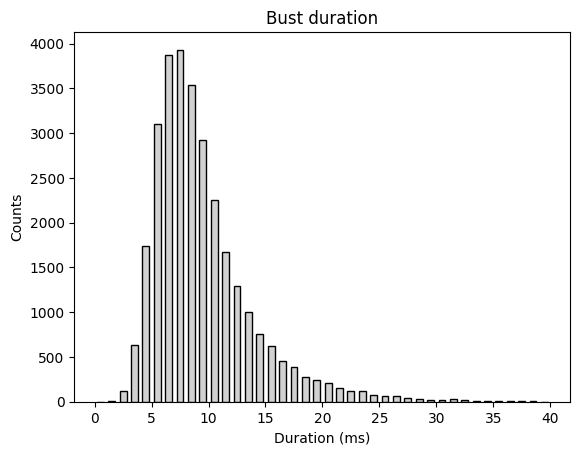

In [19]:
plt.title('Bust duration')
counts_bd, bins_bd, patches_bd =  plt.hist(df['Duration (ms)'], bins=np.linspace(0, 40, 41), log=False, rwidth=0.6, linewidth=1., edgecolor='black', fc=(0.1, 0.1, 0.1, 0.2))
plt.xlabel('Duration (ms)')
plt.ylabel('Counts')
# Mean Duration
number_of_tws_in_mode = 3
mean_dur = counts_bd @ bins_bd[1:] / np.sum(counts_bd)
minimum_window_length = (mean_dur / 1000.0) / number_of_tws_in_mode
print("Mean Duration {:.1f} ms".format(mean_dur))

Text(0, 0.5, 'Counts')

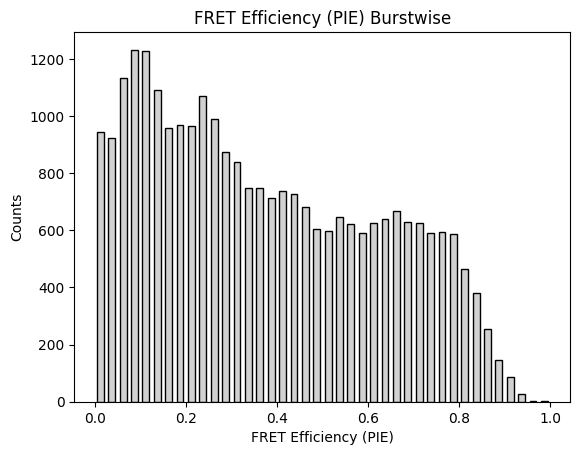

In [20]:
plt.title('FRET Efficiency (PIE) Burstwise')
counts_FE, bins_FE, patches_FE =  plt.hist(df['FRET Efficiency (PIE)_Burst'], bins=np.linspace(0, 1, 41), log=False, rwidth=0.6, linewidth=1., edgecolor='black', fc=(0.1, 0.1, 0.1, 0.2))
plt.xlabel('FRET Efficiency (PIE)')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

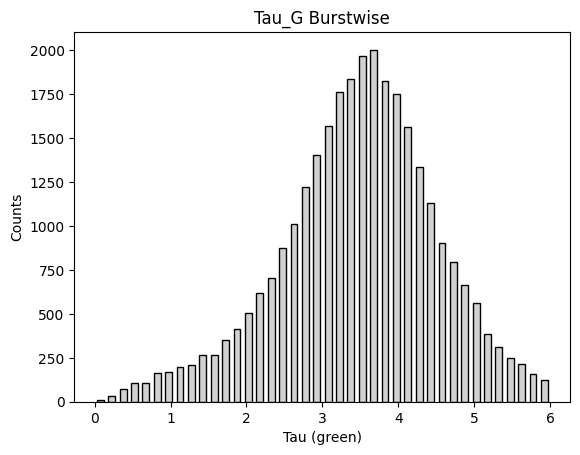

In [21]:
df['Tau (green)'] = df['Tau (green)'].astype(float) ## Convert To Float This columns did not convert co numeric see warning above
plt.title('Tau_G Burstwise')
counts_TG, bins_TG, patches_TG =  plt.hist(df['Tau (green)'], bins=np.linspace(0, 6, 41), log=False, rwidth=0.6, linewidth=1., edgecolor='black', fc=(0.1, 0.1, 0.1, 0.2))
plt.xlabel('Tau (green)')
plt.ylabel('Counts')

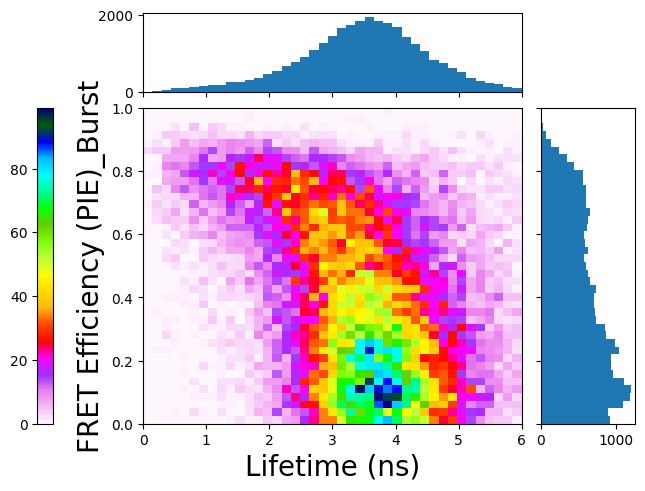

In [22]:
[xmin, xmax], [ymin, ymax] = (0, 6), (0, 1)
bins = 41, 41
#vmin, vmax = 0.1, 41
nx, ny = make_plot(df['Tau (green)'], df['FRET Efficiency (PIE)_Burst'], 
          'Lifetime (ns)', 'FRET Efficiency (PIE)_Burst', 41, 41)

Text(0, 0.5, 'Events')

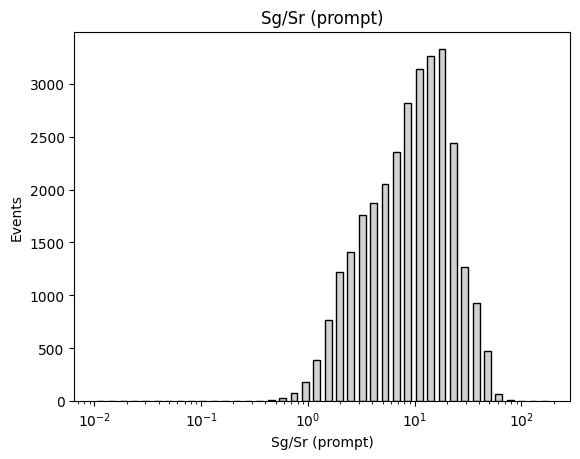

In [23]:
plt.title('Sg/Sr (prompt)')
counts_SgSr, bins_SgSr, patches_SgSr =  plt.hist(df['Sg/Sr (prompt)_Burst'], bins=np.logspace(np.log10(0.01), np.log10(185), 41), log=False, rwidth=0.6, linewidth=1., edgecolor='black', fc=(0.1, 0.1, 0.1, 0.2))
plt.xscale('log')
plt.xlabel('Sg/Sr (prompt)')
plt.ylabel('Events')

Text(0, 0.5, 'Events')

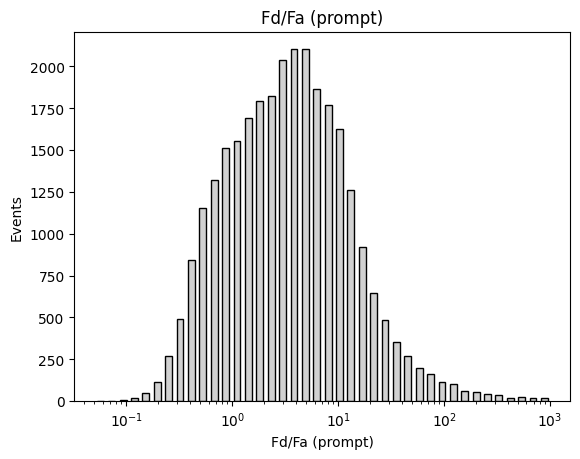

In [24]:
plt.title('Fd/Fa (prompt)')
counts_FdFa, bins_FdFa, patches_FdFa =  plt.hist(df['Fd/Fa (prompt)_Burst'], bins=np.logspace(np.log10(0.05), np.log10(1000), 41), log=False, rwidth=0.6, linewidth=1., edgecolor='black', fc=(0.1, 0.1, 0.1, 0.2))
plt.xscale('log')
plt.xlabel('Fd/Fa (prompt)')
plt.ylabel('Events')

Text(0, 0.5, 'Events')

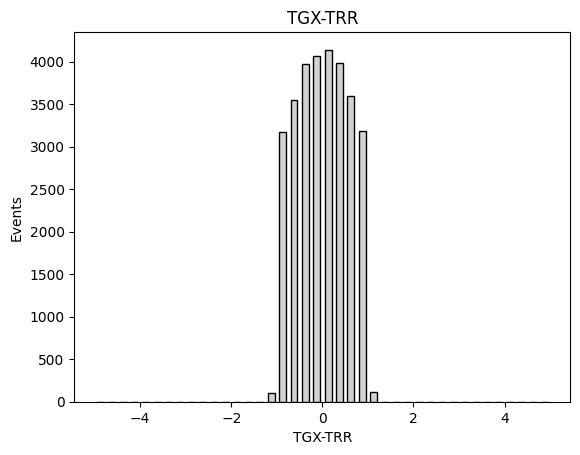

In [25]:
plt.title('TGX-TRR')
counts_TgTr, bins_TgTr, patches_TgTr =  plt.hist(df['TGX-TRR\n'], bins=np.linspace(-5, 5, 41), log=False, rwidth=0.6, linewidth=1., edgecolor='black', fc=(0.1, 0.1, 0.1, 0.2))
plt.xlabel('TGX-TRR')
plt.ylabel('Events')

Text(0, 0.5, 'Events')

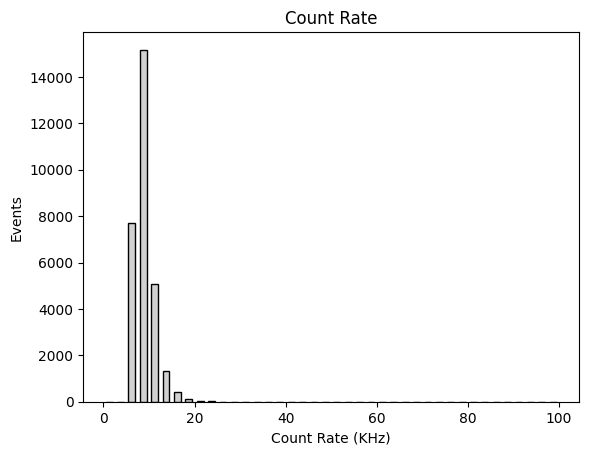

In [26]:
plt.title('Count Rate')
counts_cr, bins_cr, patches_cr =  plt.hist(df['Count Rate (KHz)'], bins=np.linspace(0, 100, 41), log=False, rwidth=0.6, linewidth=1., edgecolor='black', fc=(0.1, 0.1, 0.1, 0.2))
plt.xlabel('Count Rate (KHz)')
plt.ylabel('Events')

## Calculate mean burst durations, Count Rate, Number of Photons

In [27]:
# Mean Duration
number_of_tws_in_mode = 3
mean_dur = counts_bd @ bins_bd[1:] / np.sum(counts_bd)
minimum_window_length = (mean_dur / 1000.0) / number_of_tws_in_mode
print("Mean Duration {:.1f} ms".format(mean_dur))

# Mean Count Rate
number_of_tws_in_mode = 3
mean_cr = counts_cr @ bins_cr[1:] / np.sum(counts_cr)
print("Mean Count Rate {:.1f} KHz".format(mean_cr))

# Mean Time for # Number of Photons
number_of_photons_per_slice = 40 # Change this every run
duration_tw = number_of_photons_per_slice/mean_cr
print("Duration Time Window {:.3f}".format(duration_tw))

Mean Duration 9.9 ms
Mean Count Rate 10.2 KHz
Duration Time Window 3.932


# Compute mean and variance in bursts

### BVA with constant time window

compute_bva_mean_std(df, minimum_window_length=minimum_window_length)

compute_bva_meanE_stdE(df, minimum_window_length=minimum_window_length)

# Filter (discrimiate zeros)
df_selected = df[df['Proximity Ratio Std'] > 0.0]

[xmin, xmax], [ymin, ymax] = (0, 1), (0, 0.85)
vmin, vmax = 0.1, 40
plt.title('Proximity Ratio')
plt.xlabel('Mean proximity ratio, M(PR)')
plt.ylabel('PR standard deviation, SD(PR)')

counts, prox_mean_bins, prox_sd_bins, _ = plt.hist2d(df_selected['Proximity Ratio Mean'], df_selected['Proximity Ratio Std'], range=[[xmin, xmax], [ymin, ymax]], bins=(31, 31), vmin=vmin, vmax=vmax)

# Filter (discrimiate zeros)
df_selected = df[df['FRET Efficiency Std'] > 0.0]

[xmin, xmax], [ymin, ymax] = (0, 1), (0, 0.85)
vmin, vmax = 0.1, 40
plt.title('FRET Efficiency')
plt.xlabel('Mean FRET Efficiency, M(E)')
plt.ylabel('FRET Efficiency std, SD(E)')

counts, FRET_mean_bins, FRET_sd_bins, _ = plt.hist2d(df_selected['FRET Efficiency Mean'], df_selected['FRET Efficiency Std'], range=[[xmin, xmax], [ymin, ymax]], bins=(31, 31), vmin=vmin, vmax=vmax)

### BVA over fixed number of photons

### Compute mean an variance for simulated static species

plt.xlabel('Mean proximity ratio, M(PR)')
plt.ylabel('PR standard deviation, SD(PR)')
for n in [10, 20, 30, 40]:
    plt.plot(*compute_static_simulated_species(number_of_photons_per_slice_sim=n), label=n)
plt.legend()

BVA Proximity Ratio

In [28]:
print(number_of_photons_per_slice)

40


  0%|                                       | 95/29870 [00:00<00:54, 541.84it/s]/var/folders/l0/m9k4xm_n34sbn08v014pzwdm0000gn/T/ipykernel_88396/2747389972.py:74: RuntimeWarning: invalid value encountered in divide
  tw_proximity_ratios = tw_n_red / (tw_n_green + tw_n_red)
100%|████████████████████████████████████| 29870/29870 [00:41<00:00, 720.88it/s]


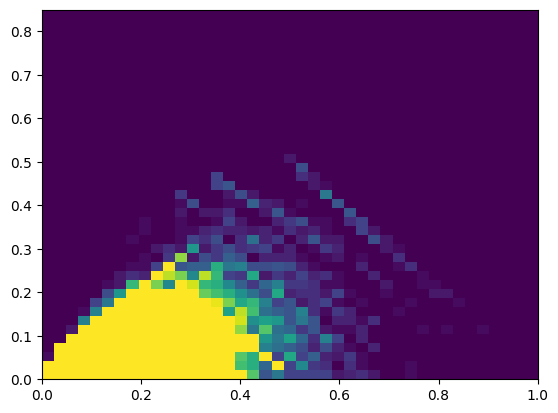

In [29]:
###########################################
###        Compute BVA Prox Ratio       ###
###########################################
compute_bva_mean_std(df, number_of_photons_per_slice=number_of_photons_per_slice)
df_selected = df[df['Proximity Ratio Std'] > 0.0]
[xmin, xmax], [ymin, ymax] = (0, 1), (0, 0.85)
vmin, vmax = 0.1, 30
counts, prox_mean_bins, prox_sd_bins, _ = plt.hist2d(df_selected['Proximity Ratio Mean'], df_selected['Proximity Ratio Std'], range=[[xmin, xmax], [ymin, ymax]], bins=(41, 41), vmin=vmin, vmax=vmax)
prox_mean_sim, prox_sd_sim = compute_static_simulated_species(number_of_photons_per_slice)

BVA FRET Efficiency

100%|███████████████████████████████████| 29870/29870 [00:18<00:00, 1587.53it/s]


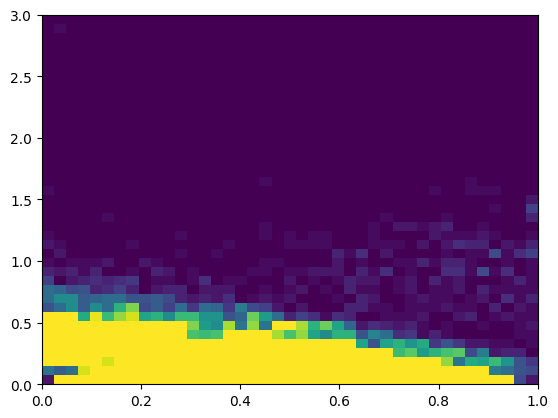

In [30]:
###########################################
###   Compute BVA FRET Efficiency       ###
###########################################
#number_of_photons_per_slice = 5
compute_bva_meanE_stdE(df, number_of_photons_per_slice=number_of_photons_per_slice)
df_selected = df[df['FRET Efficiency Std'] > 0.0]
[xmin, xmax], [ymin, ymax] = (0, 1), (0, 3)
vmin, vmax = 0.1, 31
counts, FRET_mean_bins, FRET_sd_bins, _ = plt.hist2d(df_selected['FRET Efficiency Mean'], df_selected['FRET Efficiency Std'], range=[[xmin, xmax], [ymin, ymax]], bins=(41, 41), vmin=vmin, vmax=vmax)
FRET_mean_sim, FRET_sd_sim = compute_static_simulated_species(number_of_photons_per_slice)

### Plot 2D BVA

/var/folders/l0/m9k4xm_n34sbn08v014pzwdm0000gn/T/ipykernel_88396/3996976887.py:17: RuntimeWarning: invalid value encountered in scalar divide
  m1 = c @ y / s
/var/folders/l0/m9k4xm_n34sbn08v014pzwdm0000gn/T/ipykernel_88396/3996976887.py:18: RuntimeWarning: invalid value encountered in scalar divide
  m2 = c @ y2 / s


<ErrorbarContainer object of 3 artists>

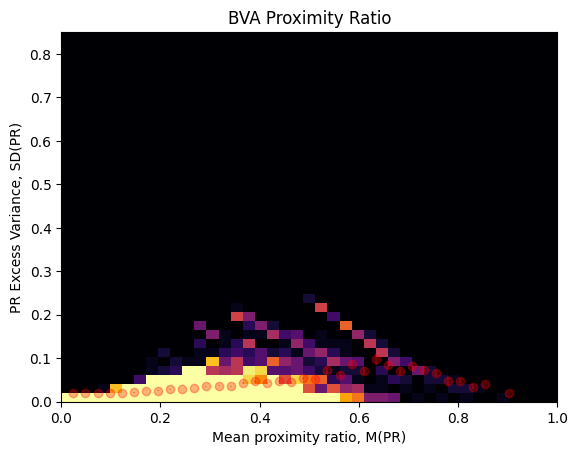

In [31]:
###########################################
### Plot 2D histogram of BVA Prox Ratio ###
###########################################

# Set up the plot settings
plt.title('BVA Proximity Ratio')
plt.xlabel('Mean proximity ratio, M(PR)')
plt.ylabel('PR Excess Variance, SD(PR)')
[xmin, xmax], [ymin, ymax] = (0, 1), (0, 0.85)
bins = 41, 41
vmin, vmax = 0.1, 20
#df_selected = df # df[df['Proximity Ratio Std'] > 0.0]
df_selected = df[df['Proximity Ratio Std'] > 0.0]

# Create the 2D histogram plot
x = df_selected['Proximity Ratio Mean']
y = df_selected['Proximity Ratio Std']**2-(df_selected['Proximity Ratio Mean']*(1-df_selected['Proximity Ratio Mean'])/number_of_photons_per_slice)
counts, prox_mean_bins, prox_sd_bins, _ = plt.hist2d(
    x, y, 
    range=[[xmin, xmax], [ymin, ymax]], 
    bins=bins, vmin=vmin, vmax=vmax,
    cmap='inferno'
)

# calculate the means and sd's for each bin.
mean, sd = average_histogram(counts, prox_mean_bins, prox_sd_bins)
#plt.plot(prox_mean_sim, prox_sd_sim, 'w')
plt.errorbar(prox_mean_bins[1:], mean, yerr=sd, fmt='or', alpha=0.3)


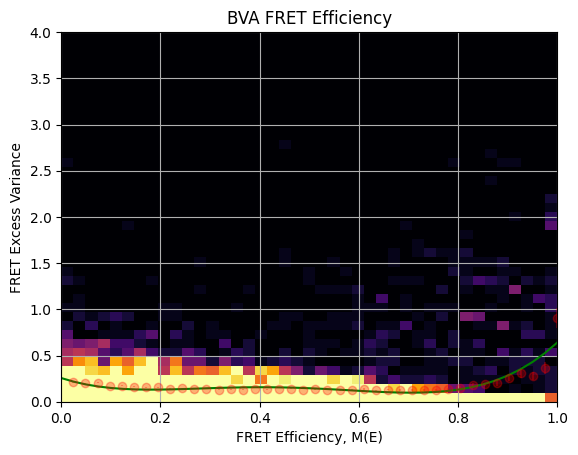

In [32]:
################################################
### Plot 2D histogram of BVA FRET Efficiency ###
################################################
plt.title('BVA FRET Efficiency')
plt.xlabel('FRET Efficiency, M(E)')
plt.ylabel('FRET Excess Variance')
[xmin, xmax], [ymin, ymax] = (0, 1), (0, 4)
bins = 41, 41
vmin, vmax = 0.1, 20
#df_selected = df # df[df['Proximity Ratio Std'] > 0.0]
df_selected = df[df['FRET Efficiency Mean'] > 0.0]
df_selected = df[df['FRET Efficiency Std'] > 0.0]

# Create the 2D histogram plot
x = df_selected['FRET Efficiency Mean']
y = df_selected['FRET Efficiency Std']**2-(df_selected['FRET Efficiency Mean']*(1-df_selected['FRET Efficiency Mean'])/number_of_photons_per_slice) # Excess Varaiance S^2 = s^2 - sigma^2, where sigma^2 = E(1-E)/m
counts, FRET_mean_bins, FRET_sd_bins, _ = plt.hist2d(
    x, y, 
    range=[[xmin, xmax], [ymin, ymax]], 
    bins=bins, vmin=vmin, vmax=vmax,
    cmap='inferno'
)

meanE, sdE = average_histogram(counts, FRET_mean_bins, FRET_sd_bins)
#plt.plot(FRET_mean_sim, FRET_sd_sim, 'w')
x_mean = FRET_mean_bins[1:]
y_mean = meanE
yerr = sdE
plt.errorbar(x_mean, y_mean, yerr, fmt='or', alpha=0.3)

################################################
#### fit 4th order polynomial to mean values ###
################################################

x = np.linspace(0, 1, len(meanE))
y = meanE

constr1 = {'x' : 0, 'y' : 0}
constr2 = {'x' : 1, 'y' : 0}

def Func(x,a,b,c,d,e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

# Writing as a general constraint problem
def FuncNew(x,params):
    return params[4]*x**4 + params[3]*x**3 + params[2]*x**2 + params[1]*x + params[0]

def ConstraintOne(params):
    return constr1['y'] - FuncNew(constr1['x'],params)

def ConstraintTwo(params):
    return constr2['y'] - FuncNew(constr2['x'],params)

def Objective(params,x,y):
    y_pred = FuncNew(x,params)
    return np.sum((y_pred - y) ** 2) # least squares

cons = [{'type':'eq', 'fun': ConstraintOne},
        {'type':'eq', 'fun': ConstraintTwo}]


sigma = np.ones(len(x))
sigma[[0, -1]] = 0.0001 # first and last points

# fit without constraints
popt1, _ = scipy.optimize.curve_fit(Func, x, y, sigma=sigma)

# use the first fit as the initial guess x0
new = scipy.optimize.minimize(Objective, x0=popt1, args=(x,y), constraints=cons)
popt2 = new.x

# fit with constraints
y_fit2 = FuncNew(x,popt2)


#PolyFit
z = np.polyfit(x, y, 4)
p = np.poly1d(z)
y_fit3 = p(x)

# plot the constrained fit line
#plt.plot(x,y_fit2, color='r')
# plot the PolyFit line
plt.plot(x,y_fit3, color='g')
plt.grid()
plt.show()


### Make Final Plot and Export

nx, ny = make_plot(df_selected['Proximity Ratio Mean'], df_selected['Proximity Ratio Std'], 
          'Mean proximity ratio, M(PR)', 'PR standard deviation, SD(PR)', 41, 41)

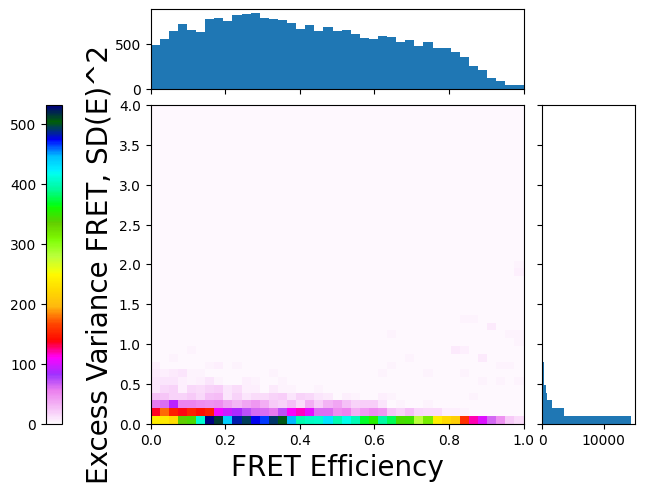

In [33]:
[xmin, xmax], [ymin, ymax] = (0, 1), (0, 4)
bins = 41, 41
vmin, vmax = 0.1, 20
x = df_selected['FRET Efficiency Mean']
y = df_selected['FRET Efficiency Std']**2-(df_selected['FRET Efficiency Mean']*(1-df_selected['FRET Efficiency Mean'])/number_of_photons_per_slice) # Excess Varaiance S^2 = s^2 - sigma^2, where sigma^2 = E(1-E)/m
nx, ny = make_plot(x, y, 
          'FRET Efficiency', 'Excess Variance FRET, SD(E)^2', 41, 41)

In [34]:
## Save files
countsdf = pd.DataFrame(counts)
countsdf.to_csv(str(file_path) + '/counts_' + str(number_of_photons_per_slice) + '_photons' + '.csv')

nxdf = pd.DataFrame(nx)
nxdf.to_csv(str(file_path) + '/nx_' + str(number_of_photons_per_slice) + '_photons' + '.csv')

nydf = pd.DataFrame(ny)
nydf.to_csv(str(file_path) + '/ny_' + str(number_of_photons_per_slice) + '_photons' + '.csv')

nmean_xdf = pd.DataFrame(x_mean)
nmean_xdf.to_csv(str(file_path) + '/meanE_' + str(number_of_photons_per_slice) + '_photons' + '.csv')

nmean_ydf = pd.DataFrame(y_mean)
nmean_ydf.to_csv(str(file_path) + '/meanvar_' + str(number_of_photons_per_slice) + '_photons' +'.csv')

nerr_ydf = pd.DataFrame(yerr)
nerr_ydf.to_csv(str(file_path) + '/errvar_' + str(number_of_photons_per_slice) + '_photons'+ '.csv')